# Qiskit 5 - Grover's search

1. Brief problem description
2. Classical solution
3. Define Quantum registers
4. State prepAration
5. Construct W
6. Construct V
7. Iterate circuit on simulation
8. Iterate cIrcuit on quantum computer

In [392]:
import numpy as np

from random import sample

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import IBMQ 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1- Brief problem description

Grover's algorithm enables one to find a specific item with a probability > $\frac{1}{2}$ within a randomly ordered database of N items using $O(\sqrt N)$ operations. Its a needle in a haystack problem basically.

Since a classical computer would require $O(N)$ operations we are looking at a quadratic speed up.

Grover's algorithm is not constraint to finding items in databases, but can be generalized to any search problem where there can be constructed a quantum oracle which distinguishes the needle from the haystack.

The construction of such quantum oracle can be reduced to the construction of a quantum cIrcuit that flips a qubit $q$ if a function $f(x)$ evaluates to 1 given some input x. The function $f(x)$ can defined as:

$f(x) = \begin{array}{22} 1 & if x = x_k \\ 0 & if x \neq x_k \end{array}$ 

Consider the function $f(x)$ as a unitary matrix $U_f$ operating on n qubits $|x\rangle_n$ and one ancillary qubit $|y\rangle$, such that:

${\bf U_f}|{\bf x} \otimes y\rangle = \frac{|x_1\rangle + |x_2\rangle + |x_3\rangle +...+ |y \oplus f(x)\rangle}{\sqrt2}$

This will lead to a phase inversion upon the item chosen by the oracle distinguishing the specific item from all other, more on that below. The next step is the invertion of the mean, here we will iteratively distinguish even further the correct item from all else. All of this to improve the probability for us to pick the correct item when we measure the state.

Keep iterate this procedure for $\sqrt N$ times.

## 2 - Classical solution

We will do 3 runs, one with N = 4, one with N = 100 and one with N = 1 000.

In [2]:
shots = 10000

N_1 = 4
X_1 = list()
for shot in range(shots):
    k = np.random.randint(N_1)
    X = sample([i for i in range(N_1)], N_1)
    for x in X:
        if x == k:
            X_1.append(x)
print('N_1 mean querys:', sum(X_1) / shots, 'prob:', round(sum(X_1) / shots / N_1, 3))

N_2 = 100
shots_2 = 100
X_2 = list()
for shot in range(shots):
    k = np.random.randint(N_2)
    X = sample([i for i in range(N_2)], N_2)
    for x in X:
        if x == k:
            X_2.append(x)
print('N_2 mean querys:', sum(X_2) / shots, 'prob:', round(sum(X_2) / shots / N_2, 3))

N_3 = 1000
X_3 = list()
for shot in range(shots):
    k = np.random.randint(N_3)
    X = sample([i for i in range(N_3)], N_3)
    for x in X:
        if x == k:
            X_3.append(x)
print('N_3 mean querys:', sum(X_3) / shots, 'prob:', round(sum(X_3) / shots / N_3, 3))

N_1 mean querys: 1.4978 prob: 0.374
N_2 mean querys: 49.3037 prob: 0.493
N_3 mean querys: 501.8659 prob: 0.502


## 3 - Define registers

We will work on two QuantumRegisters, representing 2 computational qubits $|{\bf x}\rangle_{0-1}$ and 1 ancilla qubit $|y\rangle$ respectively. Furthermore we will make use of one 2 bit ClassicalRegister for measurements.

In [242]:
x = QuantumRegister(2, 'x')
y = QuantumRegister(1, 'y')
c = ClassicalRegister(2, 'c')

## 4 - State preperation

We want to flip the ancillary qubit $|y\rangle$ and put it in a superposition with the computational qubits $|{\bf x}\rangle$, such that:

$${\bf H^{\otimes_2}}|{\bf x}\rangle \otimes - |y\rangle = \frac{|00\rangle + |01\rangle + 10\rangle + |11\rangle - |y\rangle}{\sqrt2}$$ 

In terms of quantum gates this will be achieved by applying a Pauli X gate on the ancillary qubit, and then a full layer of Hadamard gates.

In [243]:
s = QuantumCircuit(x, y, c)
s.barrier(x)
s.h(x)
s.x(y)
s.h(y)
s.barrier()
circuit_drawer(s)

## 5 - Construct W - phase shift - oracle

The item we are looking for can be held by 2 qubits and is a binary bitstring of length 2 * 2 = 4 and can therefore take the binary form from 00 - 11, which corresponds to the set of integers ${\mathbb N_{0-3}}$.

* Let the item a that we are looking for be the bitstring 10, which represents the integer 2.

When it comes to the unitary W, we want to apply control units on all computational qubits and a target unit on the ancillary qubit. This is achieved solely by the application of 1 and 2 qubits gates and is called a tofolli gate.

Besides the tofolli gate, we are to sandwich the control unit on each computational qubit that corresponds to a zero in the bitstring item that we are looking for with Pauli X gates. This will allow us to mold out the item we are looking for.

The goal of this entire process is to shift the superpositon such that the probability of finding the state in a state of 101 is higher than to find it in any other state. In the next operation V we will make the state picked out in this operation stand out even more.

In [168]:
a = 2 # 10 
W = QuantumCircuit(x, y, c)
# First layer of the Pauli X gate sandwich
for i in range(len(x)):
    if (a & (1 << i)):
        W.x(x[i])
    else:
        W.barrier(i)
W.barrier(y)
# Tofolli gate
W.ccx(x[0], x[1], y)
# Second layer of the Pauli X sandwich
for i in range(len(x)):
    if (a & (1 << i)):
        W.x(x[i])
    else:
        W.barrier(i)
W.barrier(y)
circuit_drawer(W)

Diagram certainly corresponds to our expectations, but lets create a temporary circuit where we add the **W** oracle to the state preparation **s** along with some measurement gates. 

Then lets execute a job for 1 000 shots and measure the results. No distinct tendencies of any kind, because of it only is the first iteration? Or is there something wrong with the unitary function picking the bit string of interest? 

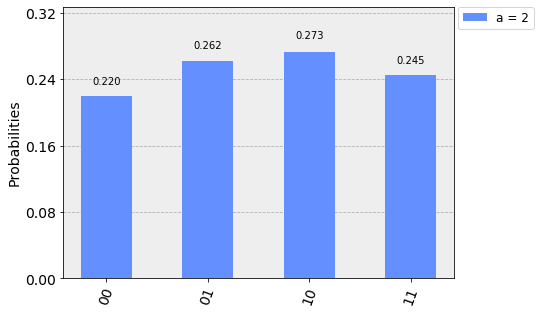

In [252]:
Wm = QuantumCircuit(x, y, c)
Wm += s + W
Wm.measure(x, [c[0], c[1]])
counts = execute(Wm, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(counts, legend=['a = ' + str(a)])

## 6 - Construct V - inversion about the mean

Here we are looking towards enhancing the square modulus of the probability amplitude corresponding to our item **a**. To achieve this we will perform inversion about the mean, which operation can be expressed as: 

$${\bf V} = 2A - I$$

In a nutshell, let $\bf U_f$ be a function that through a phase inversion picks out a specific bitstring from the input vector **s**, and let the output vector from this function be **s^**. Take the average **A** of the output **s^**, multiply it by 2 and add it to the negative **a**.

In terms of quantum gates, see more below.

In [171]:
V = QuantumCircuit(x, y, c)
V.h(x)
V.x(x)
V.barrier(x[0])
V.h(x[1])
V.cx(x[0], x[1])
V.barrier(x[0])
V.h(x[1])
V.x(x)
V.h(x)
circuit_drawer(V)

Lets see what it looks like if we add it to the s + W circuits and measure it. 

The result below tells us that after one iteration of the Grover operator, it have picked and magnified the state 01 for us. Is this a correct result? The answer is no. 

First of all, we are looking for the item 2 with which bitstring 10 we encoded our oracle with, hence the result of 01 is wrong. Secondly as we will discover more thoroughly below, in order for one to expect the Grover operator to receive a correct answer, one is to iterate the Grover operator for $\sqrt 2^n$ times.

Hence the number of iterations for us to consider is:

$$iterations = \sqrt{s^4} = \sqrt16 = 4$$

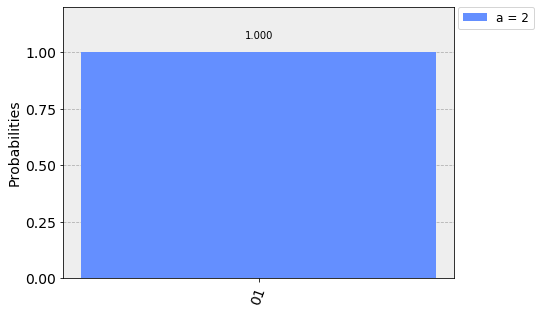

In [245]:
Vm = QuantumCircuit(x, y, c)
Vm += s + W + V
Vm.measure(x, c)
counts = execute(Vm, Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(counts, legend=['a = ' + str(a)])

## 7.1 - Iterate circuit on simulation



In [246]:
num_iterations = 4

G = QuantumCircuit(x, y, c)
for i in range(num_iterations):
    G += s + W + V
    G.barrier()
G.barrier()
G.barrier()
G.measure(x, c)
#circuit_drawer(G)

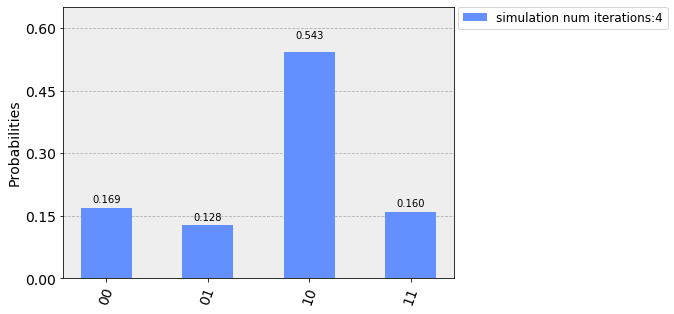

In [249]:
count_sim = execute(G, sim, shots=1000).result().get_counts()
plot_histogram(count_sim, legend=['simulation num iterations:' + str(num_iterations)])

## 7.2 - Plot Grover iterations

* Iterate over total_iterations of Grover operations
* Measure each system and do an argmax on the result
* Append the argmax and plot the result

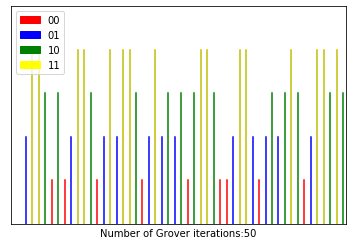

In [335]:
tot_iterations = 50
result = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():
        keys.append(k)
        values.append(v)
    ind = trans[str(keys[np.argmax(values)])]
    result.append(ind)
ax = [i + 1 for i in range(tot_iterations)]
for i in range(tot_iterations):
    color = ['r', 'b', 'g', 'y'][result[i]]
    plt.axvline(x=ax[i], ymax=(0.2 * (1 + result[i])), color=color)
plt.xticks([])
plt.xlabel('Number of Grover iterations:' + str(tot_iterations))
plt.yticks([])
red_patch = mpatches.Patch(color='red', label='00')
blue_patch = mpatches.Patch(color='blue', label='01')
green_patch = mpatches.Patch(color='green', label='10')
yellow_patch = mpatches.Patch(color='yellow', label='11')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])
plt.show()  

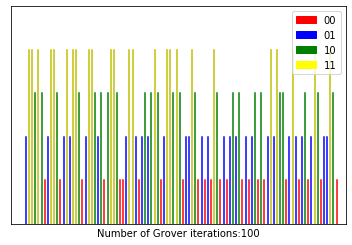

In [334]:
tot_iterations = 100
result = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():
        keys.append(k)
        values.append(v)
    ind = trans[str(keys[np.argmax(values)])]
    result.append(ind)
ax = [i + 1 for i in range(tot_iterations)]
for i in range(tot_iterations):
    color = ['r', 'b', 'g', 'y'][result[i]]
    plt.axvline(x=ax[i], ymax=(0.2 * (1 + result[i])), color=color)
plt.xticks([])
plt.xlabel('Number of Grover iterations:' + str(tot_iterations))
plt.yticks([])
red_patch = mpatches.Patch(color='red', label='00')
blue_patch = mpatches.Patch(color='blue', label='01')
green_patch = mpatches.Patch(color='green', label='10')
yellow_patch = mpatches.Patch(color='yellow', label='11')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])
plt.show()    

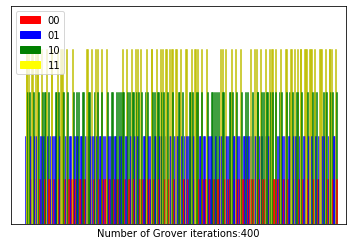

In [336]:
tot_iterations = 400
result = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():
        keys.append(k)
        values.append(v)
    ind = trans[str(keys[np.argmax(values)])]
    result.append(ind)
ax = [i + 1 for i in range(tot_iterations)]
for i in range(tot_iterations):
    color = ['r', 'b', 'g', 'y'][result[i]]
    plt.axvline(x=ax[i], ymax=(0.2 * (1 + result[i])), color=color)
plt.xticks([])
plt.xlabel('Number of Grover iterations:' + str(tot_iterations))
plt.yticks([])
red_patch = mpatches.Patch(color='red', label='00')
blue_patch = mpatches.Patch(color='blue', label='01')
green_patch = mpatches.Patch(color='green', label='10')
yellow_patch = mpatches.Patch(color='yellow', label='11')
plt.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])
plt.show()  

## 7.3 - Correct answer probability evolution

We would like to get a feel for how the probabilities for the correct item change with additional Grover iterations. Is the expected shape concave? Is the optimum chance of picking the correct item at $\sqrt N^2$ iterations? Or does it perhaps improve further don the road?

Lets have a quick glance at this by a similar setup as the classical solution. Run the iterations, extract the correct item and run an amax on it, then append these values along with their iteration indicies and plot it.

We can see that a repeating fact is that the probability seems to be $frac{1}{2}$ like clockwork on the $\sqrt 2^N$ iteration. Is this to be interpreted such that it performs 'as well as a classical computer does in $\sqrt 2^N$?

We can furthermore see an initially rising pattern and then a wave like pattern. One thing to note is that it is never 100% certain. Note furthermore the dramatic drop instantly after a peak, perhaps due to the invertion of mean, inverting it again after it is as distinguished it possibly could be somehow resets it.

They key lesson here though is that you want to run the Grover operator for $\sqrt 2^N$ iterations in order to obtain the same results a classical solution. No more, no less.

<Figure size 432x288 with 0 Axes>

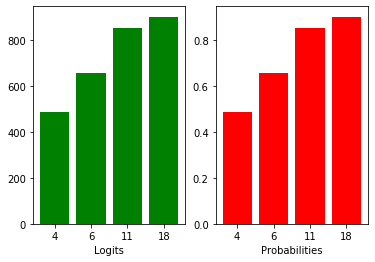

In [384]:
tot_iterations = 20
result = list()
xlabel = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():`
        keys.append(k)
        values.append(v)
    ind = trans[keys[np.argmax(values)]]
    if ind == 2:
        result.append(count[keys[np.argmax(values)]])
        xlabel.append(tot + 1)
plt.figure(figsize=(6, 4))
plt.subplots(1, 2, sharex=True)
y_pos = np.arange(len(result))
plt.subplot(1,2,1)
plt.bar(y_pos, result, color='g', label='10: Logits')
plt.xticks(y_pos, xlabel)
plt.xlabel('Logits')
plt.subplot(1,2,2)
plt.bar(y_pos, [i / 1000 for i in result], color='red', label='10: Probabilities')
plt.xticks(y_pos, xlabel)
plt.xlabel('Probabilities')
plt.show()

<Figure size 432x288 with 0 Axes>

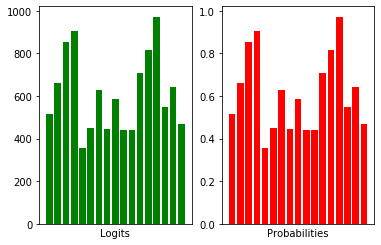

In [389]:
tot_iterations = 75
result = list()
xlabel = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():
        keys.append(k)
        values.append(v)
    ind = trans[keys[np.argmax(values)]]
    if ind == 2:
        result.append(count[keys[np.argmax(values)]])
        xlabel.append(tot + 1)
plt.figure(figsize=(6, 4))
plt.subplots(1, 2, sharex=True)
y_pos = np.arange(len(result))
plt.subplot(1,2,1)
plt.bar(y_pos, result, color='g', label='10: Logits')
plt.xticks([])
plt.xlabel('Logits')
plt.subplot(1,2,2)
plt.bar(y_pos, [i / 1000 for i in result], color='red', label='10: Probabilities')
plt.xticks([])
plt.xlabel('Probabilities')
plt.show()

<Figure size 432x288 with 0 Axes>

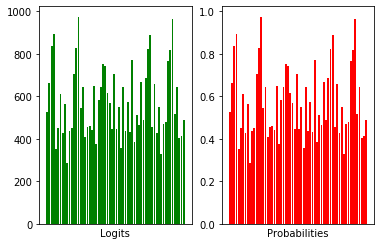

In [390]:
tot_iterations = 250
result = list()
xlabel = list()
for tot in range(tot_iterations):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
    count = execute(G, sim, shots=1000).result().get_counts()
    trans = {'00': 0, '01': 1, '10': 2, '11': 3}
    keys = list()
    values = list()
    for k, v in count.items():
        keys.append(k)
        values.append(v)
    ind = trans[keys[np.argmax(values)]]
    if ind == 2:
        result.append(count[keys[np.argmax(values)]])
        xlabel.append(tot + 1)
plt.figure(figsize=(6, 4))
plt.subplots(1, 2, sharex=True)
y_pos = np.arange(len(result))
plt.subplot(1,2,1)
plt.bar(y_pos, result, color='g', label='10: Logits')
plt.xticks([])
plt.xlabel('Logits')
plt.subplot(1,2,2)
plt.bar(y_pos, [i / 1000 for i in result], color='red', label='10: Probabilities')
plt.xticks([])
plt.xlabel('Probabilities')
plt.show()

## Iterate circuit on quantum computer



In [393]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [403]:
backend = provider.get_backend('ibmq_ourense')

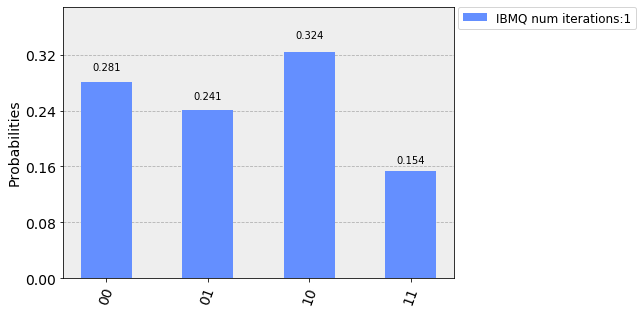

In [407]:
num_iterations = 1
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

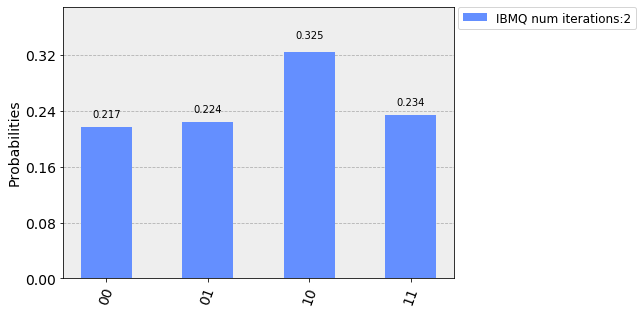

In [408]:
num_iterations = 2
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

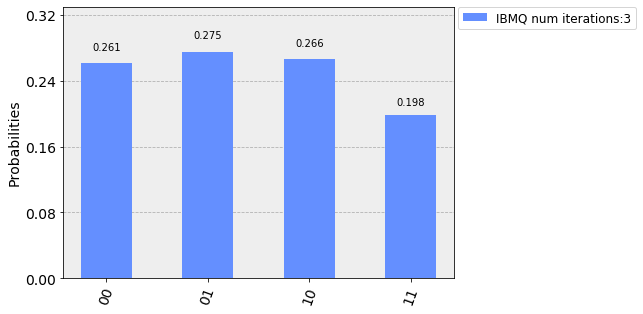

In [409]:
num_iterations = 3
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

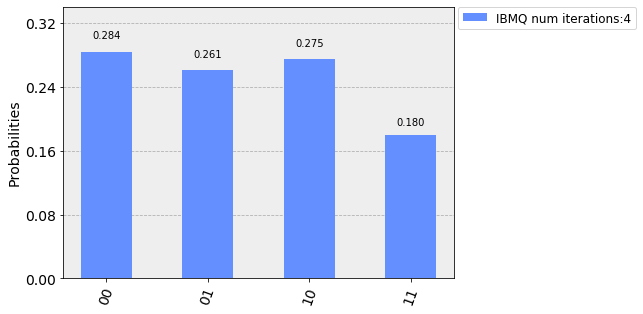

In [410]:
num_iterations = 4
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

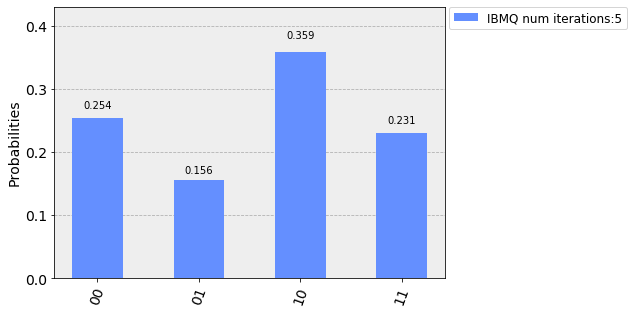

In [411]:
num_iterations = 5
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

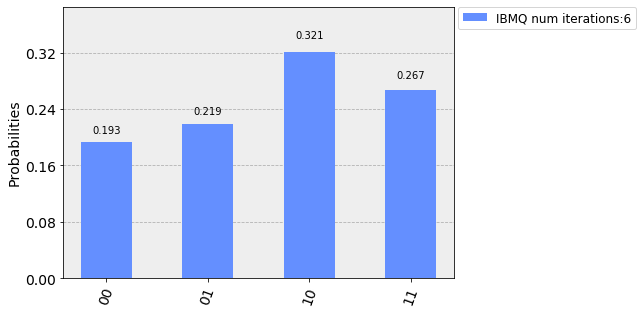

In [412]:
num_iterations = 6
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

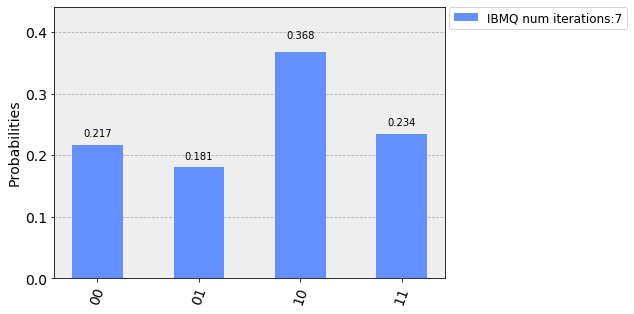

In [413]:
num_iterations = 7
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

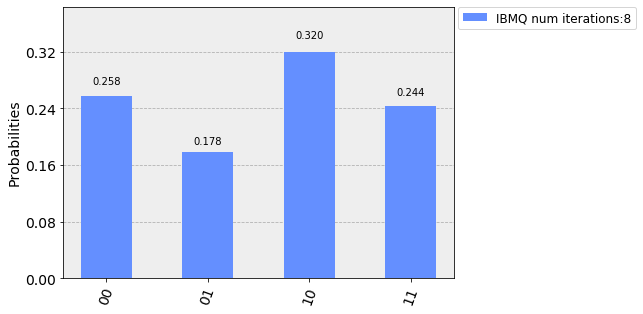

In [414]:
num_iterations = 8
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])

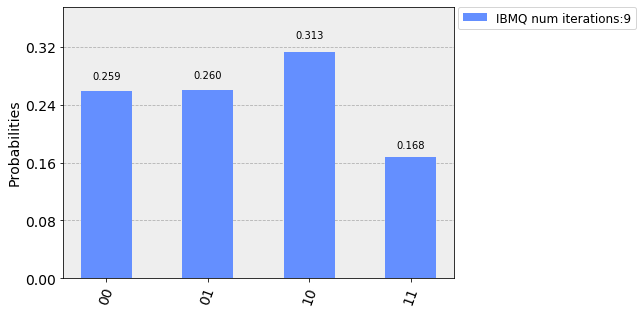

In [415]:
num_iterations = 9
for tot in range(4):
    G = QuantumCircuit(x, y, c)
    for num in range(tot + 1):
        G += s + W + V
    G.measure(x, c)
count = execute(G, backend, shots=1000).result().get_counts()
plot_histogram(count, legend=['IBMQ num iterations:' + str(num_iterations)])